# Transpolar drift inflow along the northern Canada Basin

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cmocean
import pandas as pd
import pickle
import xarray as xr
import matplotlib
import gsw

%matplotlib inline

#### Parameters

In [12]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

# Boundary coordinates:
N_coordinates = ((2168, 2178, 201, 798))
E_coordinates = ((1481, 2178, 778, 798))
S_coordinates = ((1482, 1492, 181, 798))

land_color = '#a9a7a2'

# results to plot:
folder_ref = f'/data/brogalla/run_storage/Mn-reference-202110/'
# folder_IC  = f'/data/brogalla/run_storage/Mn-IC-202204/'
folder_new = f'/data/brogalla/run_storage/Mn-reference-202204/'

#### Load files

In [8]:
model_ref    = nc.Dataset(f'{folder_ref}ANHA12_ref-spin-up3_20211012/ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20020101-20020105.nc')
lon_model    = np.array(model_ref.variables['nav_lon'])
lat_model    = np.array(model_ref.variables['nav_lat'])
depths_model = np.array(model_ref.variables['deptht'])

In [9]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
e1t_base  = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base  = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t       = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)
nav_lev   = np.array(mask.variables['nav_lev'])
lons      = np.array(mask.variables['nav_lon'])

e1t       = np.tile(e1t_base, (50,1,1))
e2t       = np.tile(e2t_base, (50,1,1))
volume    = e1t*e2t*e3t
area_base = e1t_base*e2t_base
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)
area_masked   = np.ma.masked_where((tmask[0,:,:] < 0.1), area_base)

In [10]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
ANHA12_lon = np.array(mesh.variables['nav_lon'])
ANHA12_lat = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

In [13]:
# Mn model run results:
fref  = xr.open_dataset(f'{folder_ref}ANHA12_ref-spin-up1_20211012/ANHA12_EXH006_2002_monthly.nc')
fnew  = xr.open_dataset(f'{folder_new}ANHA12_ref-spin-up1_20220422/ANHA12_EXH006_2002_monthly.nc')
dMn_ref  = fref['dissolmn'].values[:,0,:,:,:]*1e9
dMn_new  = fnew['dissolmn'].values[:,0,:,:,:]*1e9
oMn_ref  = fref['oxidismn'].values[:,0,:,:,:]*1e9
oMn_new  = fnew['oxidismn'].values[:,0,:,:,:]*1e9

In [14]:
folder_data = '/ocean/brogalla/GEOTRACES/data/'
sw          = xr.open_dataset(f'{folder_data}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_kYw7mpQ2.nc')
GTR_lons    = sw['longitude'].values # degrees east
GTR_lats    = sw['latitude'].values  # degrees north
GTR_pres    = sw['var1'].values      # Pressure from CTD sensor [dbar]
GTR_depth   = sw['var2'].values      # Depth below sea surface calculated from pressure [m]
GTR_temp    = sw['var3'].values      # Temperature from CTD sensor in the ITS-90 convention. [C]
GTR_sal     = sw['var4'].values      # Practical salinity from CTD sensor on the PSS-1978 scale
GTR_dMn     = sw['var12'].values     # Concentration of dissolved Mn in nmol/kg, method may include Mn(II) plus Mn(III)

In [15]:
# Concentration of dMn in the Beaufort Sea in 2009.
IPY = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Nari_Sim_dMn_data.csv')
IPY_names_full = IPY['Station name'].astype('string').values
IPY_depths     = IPY['Depth [m]'].astype('float').values
IPY_dMn_nmolkg = IPY['DMn [ nmol/kg]'].astype('float').values
IPY_lons_full  = -1*IPY['Longitude'].astype('float').values
IPY_lats_full  = IPY['Latitude'].astype('float').values

# Convert nmol / kg to nmol / L
IPY_density             = IPY['Density'].astype('float').values # kg / L
IPY_depths_cruise_sheet = IPY['Depth [m] cruise sheet'].astype('float').values
IPY_dMn_nmolL = IPY_dMn_nmolkg * IPY_density * 1e-3

In [16]:
IPY_dMn_PML = np.ma.masked_where(IPY_depths > 35, IPY_dMn_nmolL)

In [17]:
GTR_pressure = np.ma.masked_where(GTR_pres < -1e8, GTR_pres)
# practical salinity --> absolute salinity (g/kg)
GTR_lons_tile  = np.tile(GTR_lons, (345,1)).transpose()
GTR_lats_tile  = np.tile(GTR_lats, (345,1)).transpose()
GTR_sal_abs    = gsw.conversions.SA_from_SP(GTR_sal, GTR_pressure, GTR_lons_tile, GTR_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
GTR_density    = gsw.density.rho_t_exact(GTR_sal_abs, GTR_temp, GTR_pressure) # kg/m3

# convert dMn from nmol/kg --> nmol/L (nmol/kg * kg/m3 * 1 m3 / 1000 L)
GTR_dMn_nM = GTR_dMn*GTR_density*1e-3

In [18]:
GTR_dMn_PML = np.ma.masked_where((GTR_depth > 35), GTR_dMn_nM)
GTR_dMn_PML = np.ma.masked_where(np.isnan(GTR_dMn_nM), GTR_dMn_PML)
GTR_dMn_PML = GTR_dMn_PML.mean(axis=1)

#### Functions

In [19]:
def plot_slice(mn_model_ref, mn_model_exp, vmax1=10, vmax2=2, savefig=False):
    
#     fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/AO-map-nobg.pickle','rb'))
    fig, ax1, ax2, ax3, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/diff-panels.pickle','rb'))

    # Plot model background field:
    ax1.set_title('Reference', fontsize=7)
    ax2.set_title('Spin-up0 new', fontsize=7)
    ax3.set_title('Difference between experiment and reference', fontsize=7)
    x_model, y_model = proj(lon_model, lat_model)
    CS1 = proj.pcolormesh(x_model, y_model, mn_model_ref, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, zorder=2, ax=ax1) #ref
    CS2 = proj.pcolormesh(x_model, y_model, mn_model_exp, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, zorder=2, ax=ax2) #exp
    CS3 = proj.pcolormesh(x_model, y_model, mn_model_exp-mn_model_ref, \
                          vmin=-vmax2, vmax=vmax2, cmap=cmocean.cm.balance, zorder=2, ax=ax3) #difference
    
    for axis in [ax1, ax2, ax3]:
        # add bathymetry contours:
        x, y = proj(ANHA12_lon, ANHA12_lat)
        proj.contour(x, y, mesh_bathy, levels=[1000,2000,3000], linewidths=0.2, colors='k', zorder=3, ax=axis)
        proj.drawcoastlines(color='#373736', linewidth=1.0, ax=axis)
        proj.plot(x[E_coordinates[0]+150:E_coordinates[1],E_coordinates[2]], \
                  y[E_coordinates[0]+150:E_coordinates[1],E_coordinates[2]], 'w--', lw=0.9, zorder=4)
        proj.plot(x[E_coordinates[0]+150:E_coordinates[1],E_coordinates[3]], \
                  y[E_coordinates[0]+150:E_coordinates[1],E_coordinates[3]], 'k--', lw=0.9, zorder=4)        
        
        proj.plot(x[N_coordinates[1]-150,N_coordinates[2]+300:N_coordinates[3]], \
                  y[N_coordinates[1]-150,N_coordinates[2]+300:N_coordinates[3]], 'c--', lw=0.9, zorder=4)
    
    for axis in [ax1, ax2]:
        # Plot observations over top:
        x_GTR, y_GTR = proj(GTR_lons, GTR_lats)
        proj.scatter(x_GTR, y_GTR, c=GTR_dMn_PML, \
                     s=10, zorder=3, edgecolor='w', linewidth=0.5, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, ax=axis)

        x_IPY, y_IPY = proj(IPY_lons_full, IPY_lats_full)    
        proj.scatter(x_IPY, y_IPY, c=IPY_dMn_PML, \
                     s=10, zorder=3, edgecolor='w', linewidth=0.5, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, ax=axis)
    
    cbar_ax1 = fig.add_axes([0.270, 0.663, 0.01, 0.09])
    cbar_ax2 = fig.add_axes([0.533, 0.663, 0.01, 0.09])
    cbar_ax3 = fig.add_axes([0.280, 0.15, 0.02, 0.16])
    
    # Colorbar:
    CBar1 = plt.colorbar(CS1, cax=cbar_ax1, ticks=np.arange(0, vmax1+2, 2))
    CBar2 = plt.colorbar(CS2, cax=cbar_ax2, ticks=np.arange(0, vmax1+2, 2))
    CBar3 = plt.colorbar(CS3, cax=cbar_ax3, ticks=np.arange(-vmax2-1, vmax2+1, 1))    
    
    for CBar in [CBar1, CBar2, CBar3]:
        CBar.ax.tick_params(labelsize=5) 
        CBar.set_label('dMn [nM]', fontsize=5)
        
    CBar3.ax.tick_params(labelsize=7) 
    CBar3.set_label('dMn change [nM]', fontsize=7)
    
    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S17-TPD-bdy.jpg', bbox_inches='tight', dpi=300)
    return

In [20]:
def calculate_depth_weighted(dMn, levels=(0,16)):
    
    dMn_weighted     = dMn[levels[0]:levels[1],:,:]*e3t[levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]: 
    depth_bottom     = np.copy(mesh_bathy[imin:imax,jmin:jmax])
    depth_bottom[depth_bottom > depths_model[levels[1]-1]] = depths_model[levels[1]-1]
                 
    # calculate average:
    dMn_weighted_ave = np.sum(dMn_weighted, axis=0) / depth_bottom
    
    return dMn_weighted_ave

#### Figures

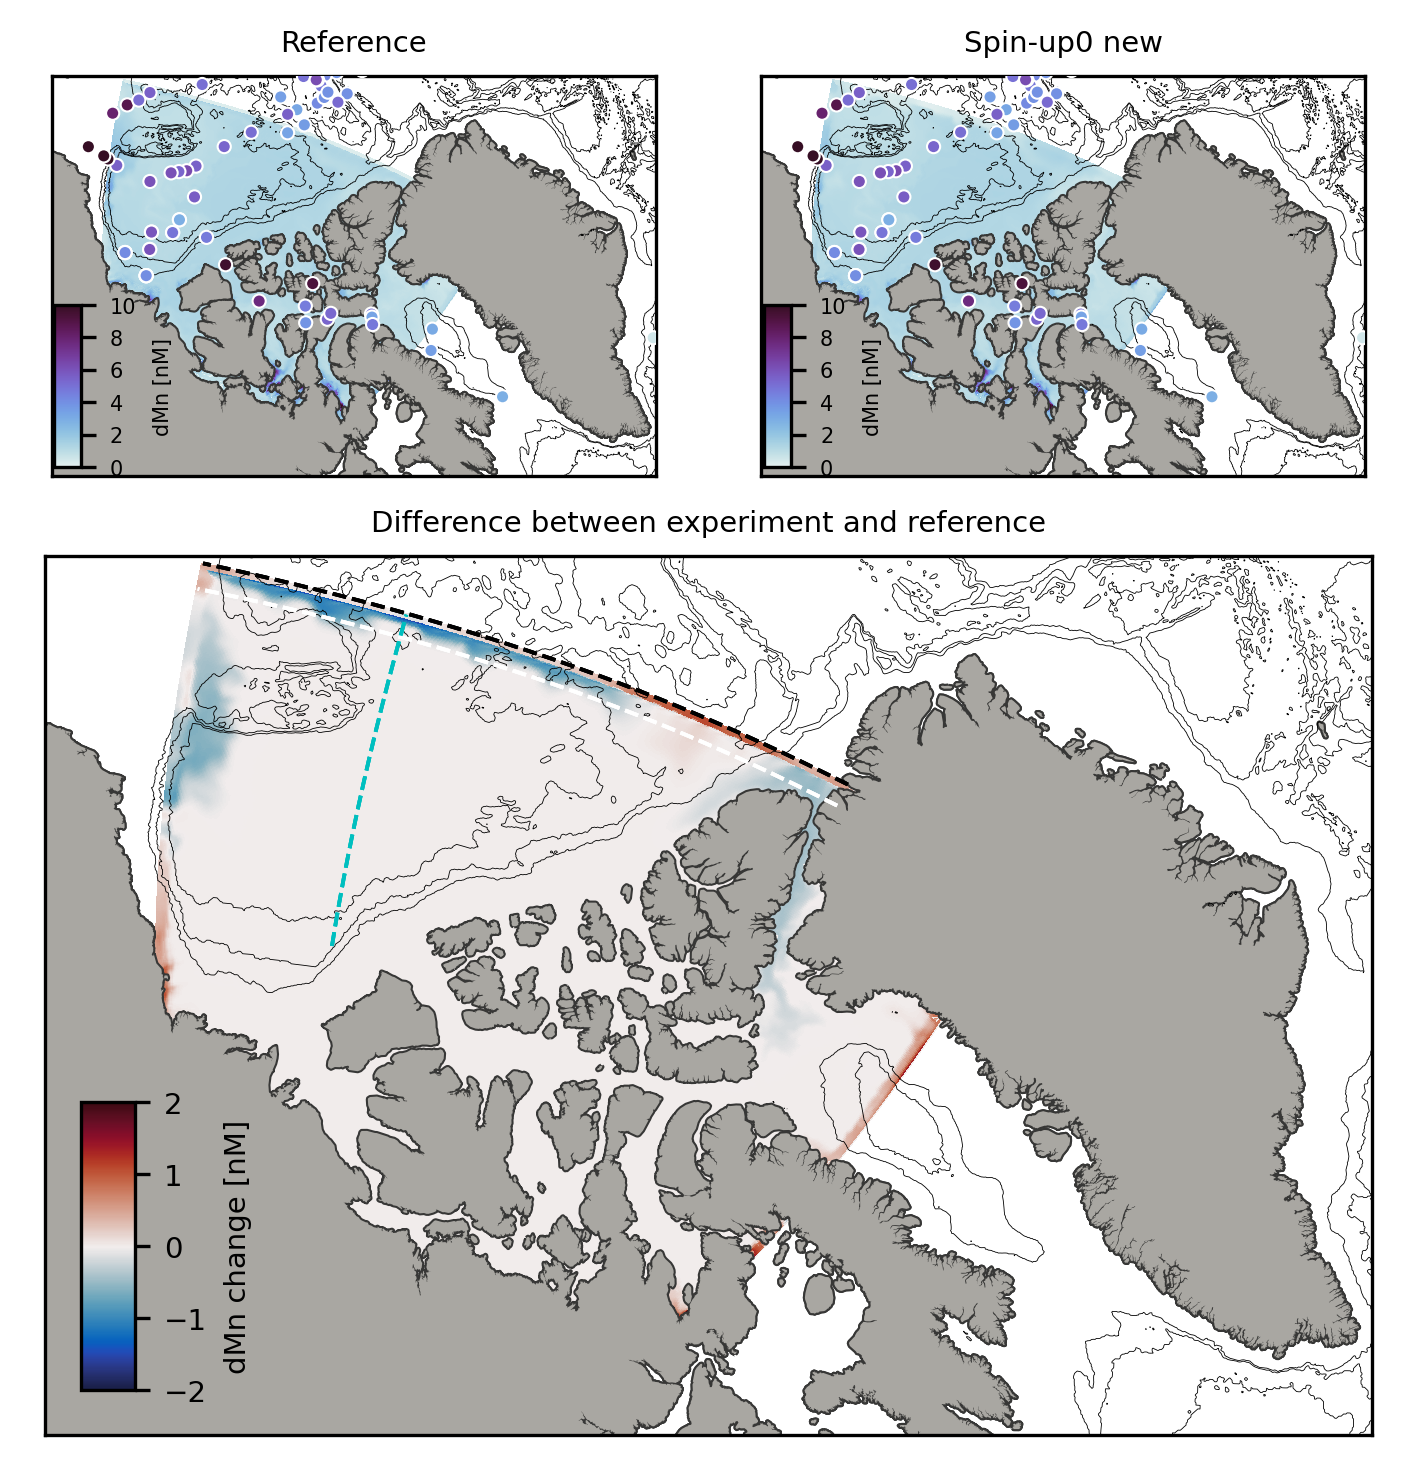

In [41]:
mn_model_ref = np.mean(dMn_ref[0:17,:,:],axis=0)
mn_model_exp = np.mean(dMn_IC[0:17,:,:],axis=0)
plot_slice(mn_model_ref, mn_model_exp, vmax1=10, vmax2=2)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


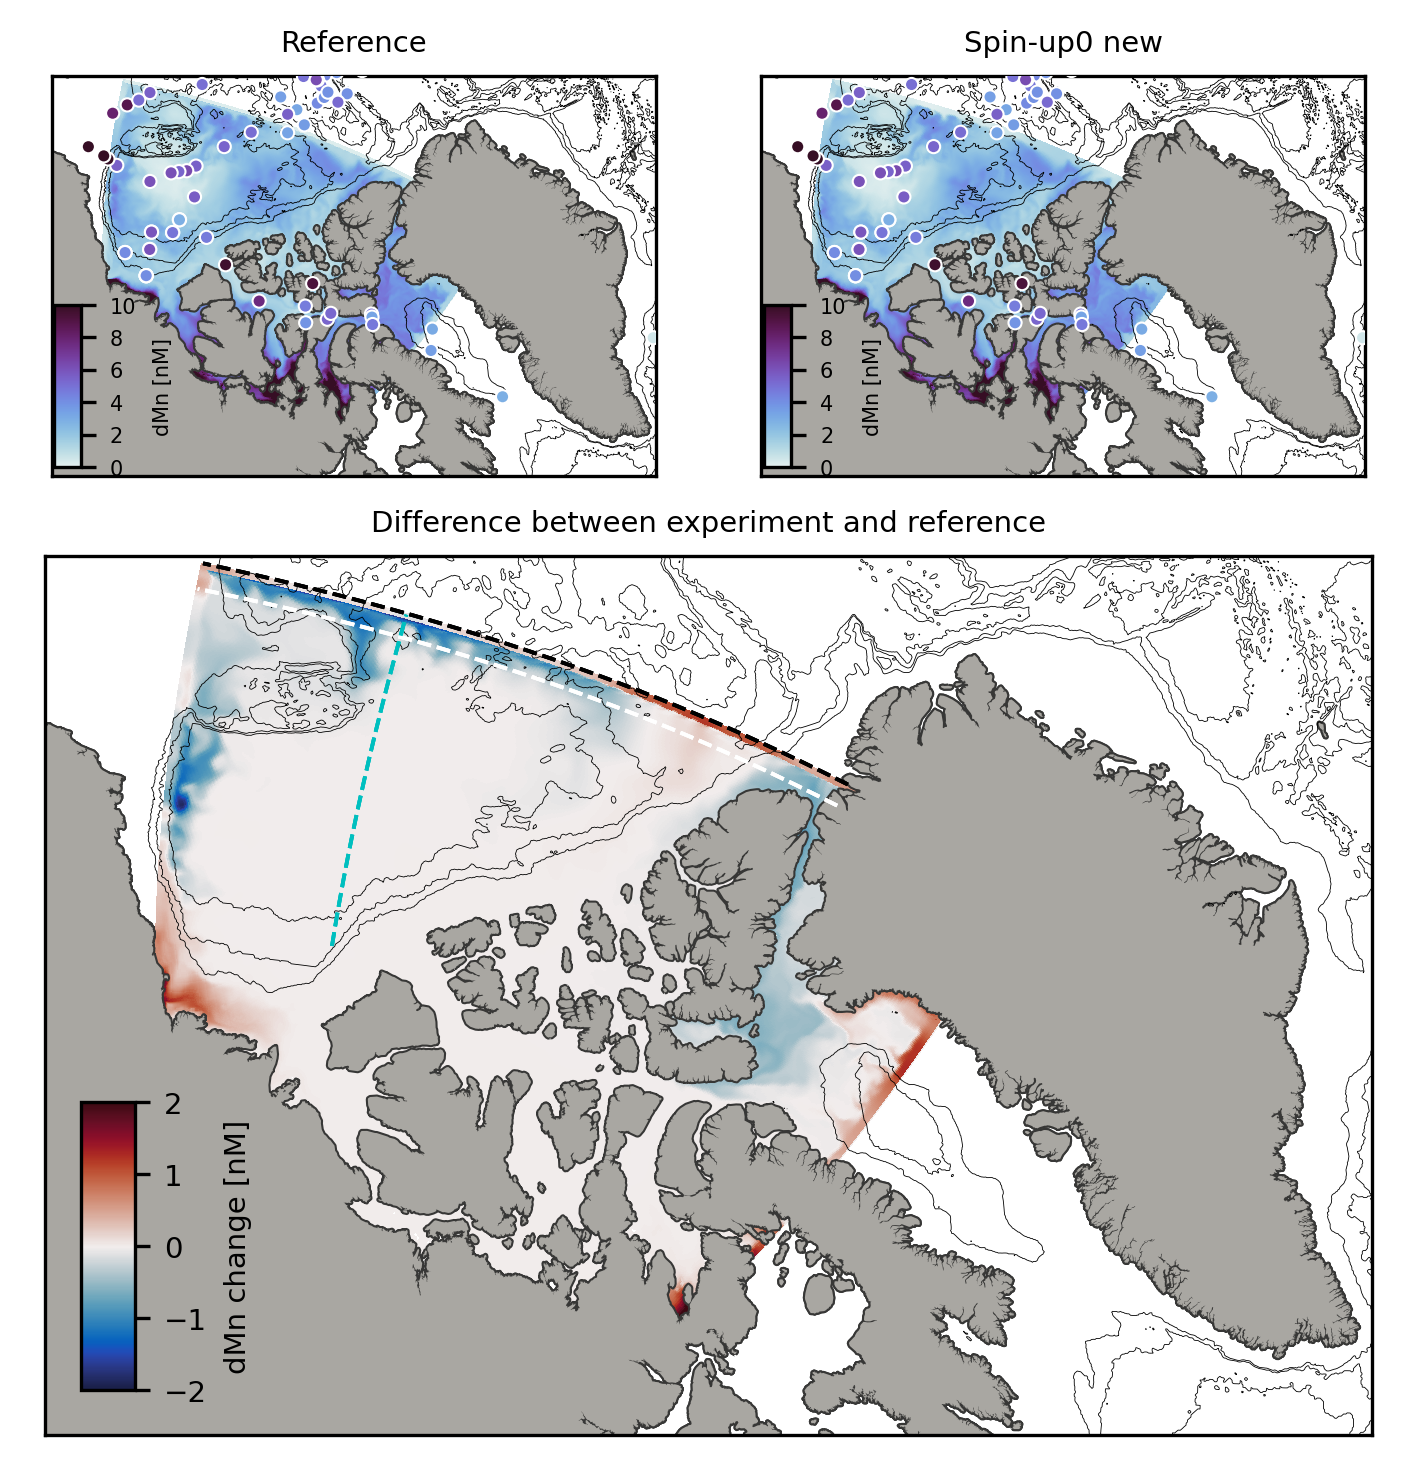

In [21]:
month=8
mn_model_ref = calculate_depth_weighted(dMn_ref[month,:,:,:])
mn_model_exp = calculate_depth_weighted(dMn_new[month,:,:,:])
plot_slice(mn_model_ref, mn_model_exp, vmax1=10, vmax2=2)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


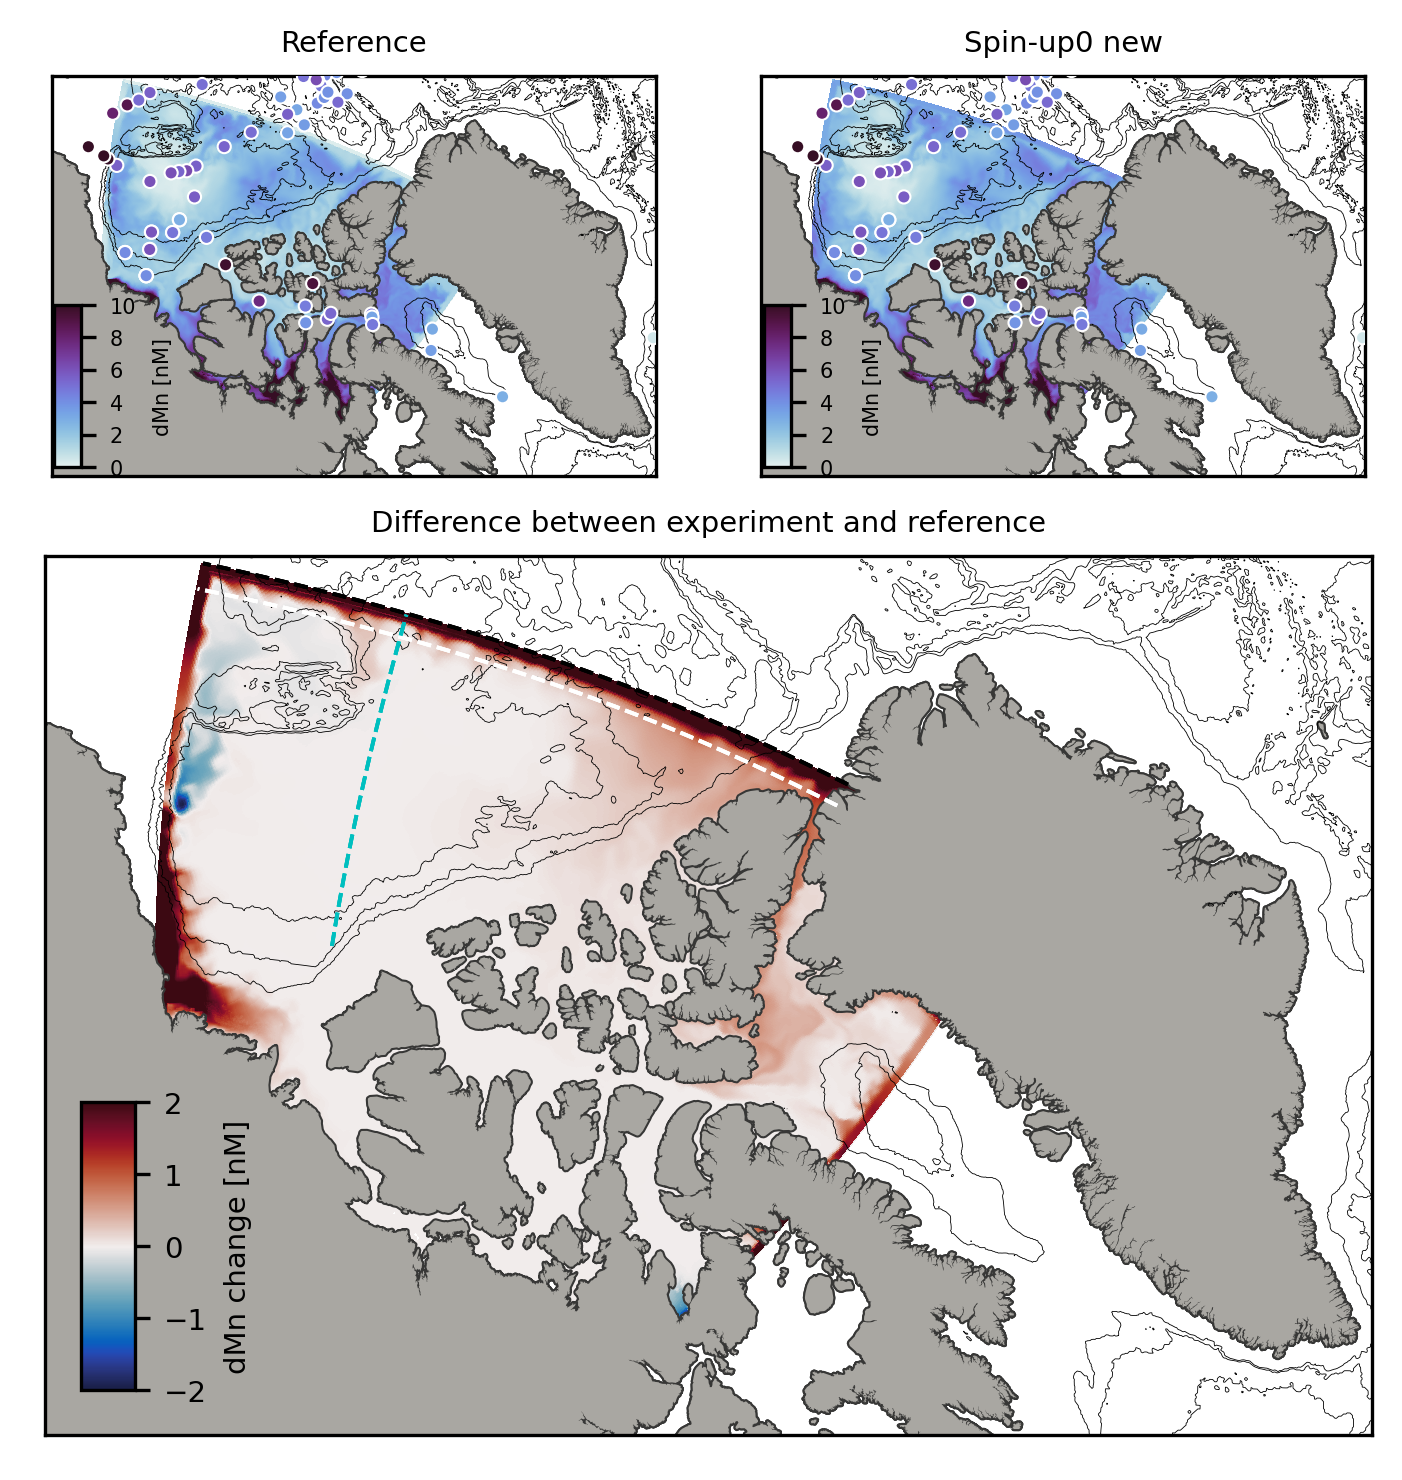

In [15]:
month=8
mn_model_ref = calculate_depth_weighted(dMn_ref[month,:,:,:])
mn_model_exp = calculate_depth_weighted(dMn_IC[month,:,:,:])
plot_slice(mn_model_ref, mn_model_exp, vmax1=10, vmax2=2)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


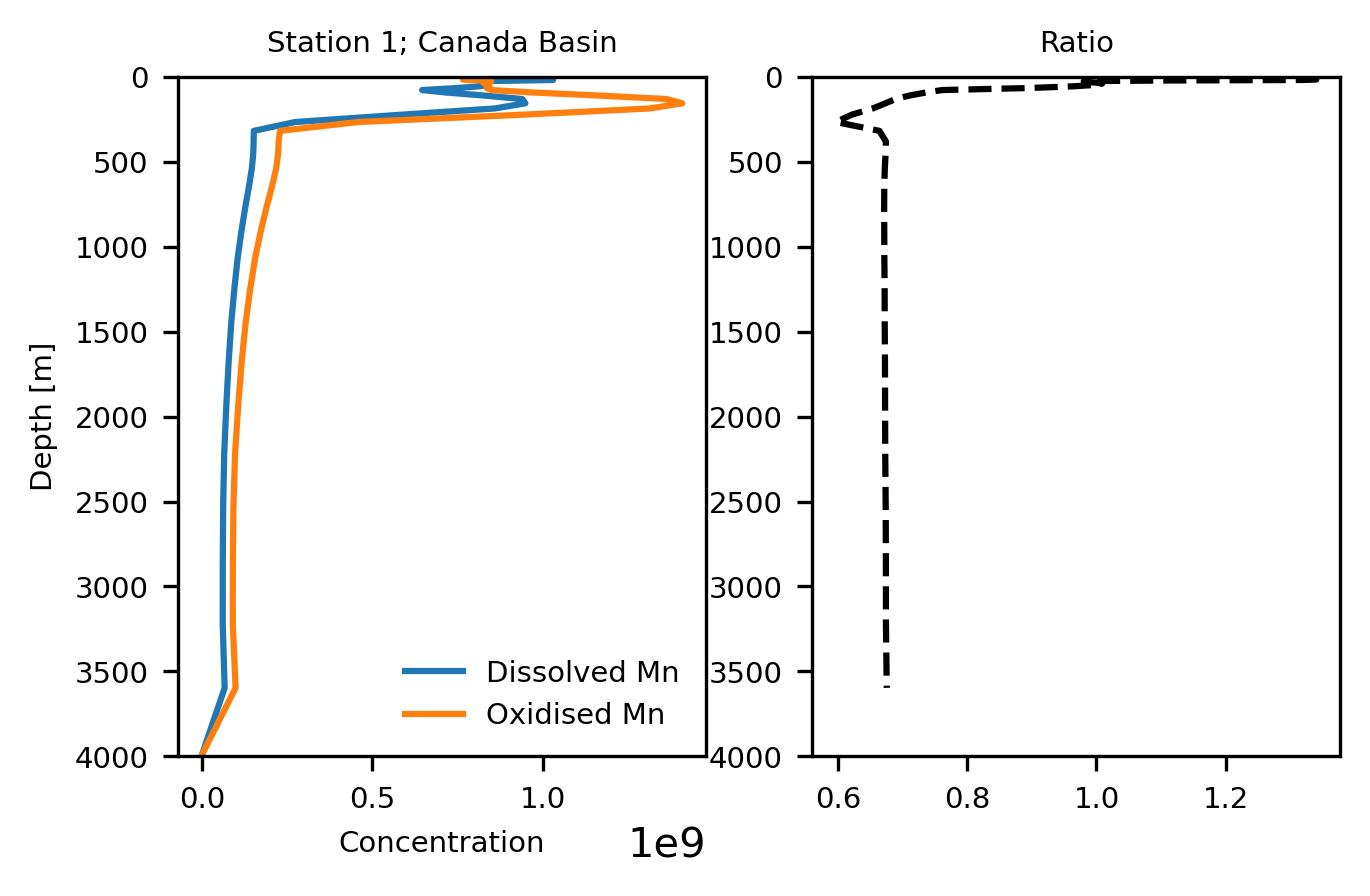

In [24]:
stn1i = 547; stn1j = 457;

fig, ax = plt.subplots(1,2, figsize=(5,3),dpi=300)
ax[0].invert_yaxis()
ax[0].set_xlabel('Concentration', fontsize=7)
ax[0].set_ylabel('Depth [m]', fontsize=7)
ax[0].plot(dMn_ref[month,:,stn1i,stn1j]*1e9, depths_model, label='Dissolved Mn')
ax[0].plot(oMn_ref[month,:,stn1i,stn1j]*1e9, depths_model, label='Oxidised Mn')
ax[0].legend(frameon=False, fontsize=7)
ax[0].set_title('Station 1; Canada Basin', fontsize=7)
ax[0].tick_params(axis='both', labelsize=7)
ax[0].set_ylim(4000,0)

ax[1].invert_yaxis()
ax[1].set_title('Ratio', fontsize=7)
ax[1].tick_params(axis='both', labelsize=7)
ax[1].set_ylim(4000,0)
ax[1].plot(np.divide(dMn_ref[month,:,stn1i,stn1j], oMn_ref[month,:,stn1i,stn1j]), depths_model, '--k')

In [26]:
month=8
mn_model_ref = calculate_depth_weighted(oMn_ref[month,:,:,:])
mn_model_exp = calculate_depth_weighted(oMn_new[month,:,:,:])
plot_slice(mn_model_ref, mn_model_exp, vmax1=10, vmax2=2)

ValueError: operands could not be broadcast together with shapes (700,640) (0,640,1632) 

In [22]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
mesh_depth   = np.array(mesh.variables['nav_lev'])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)

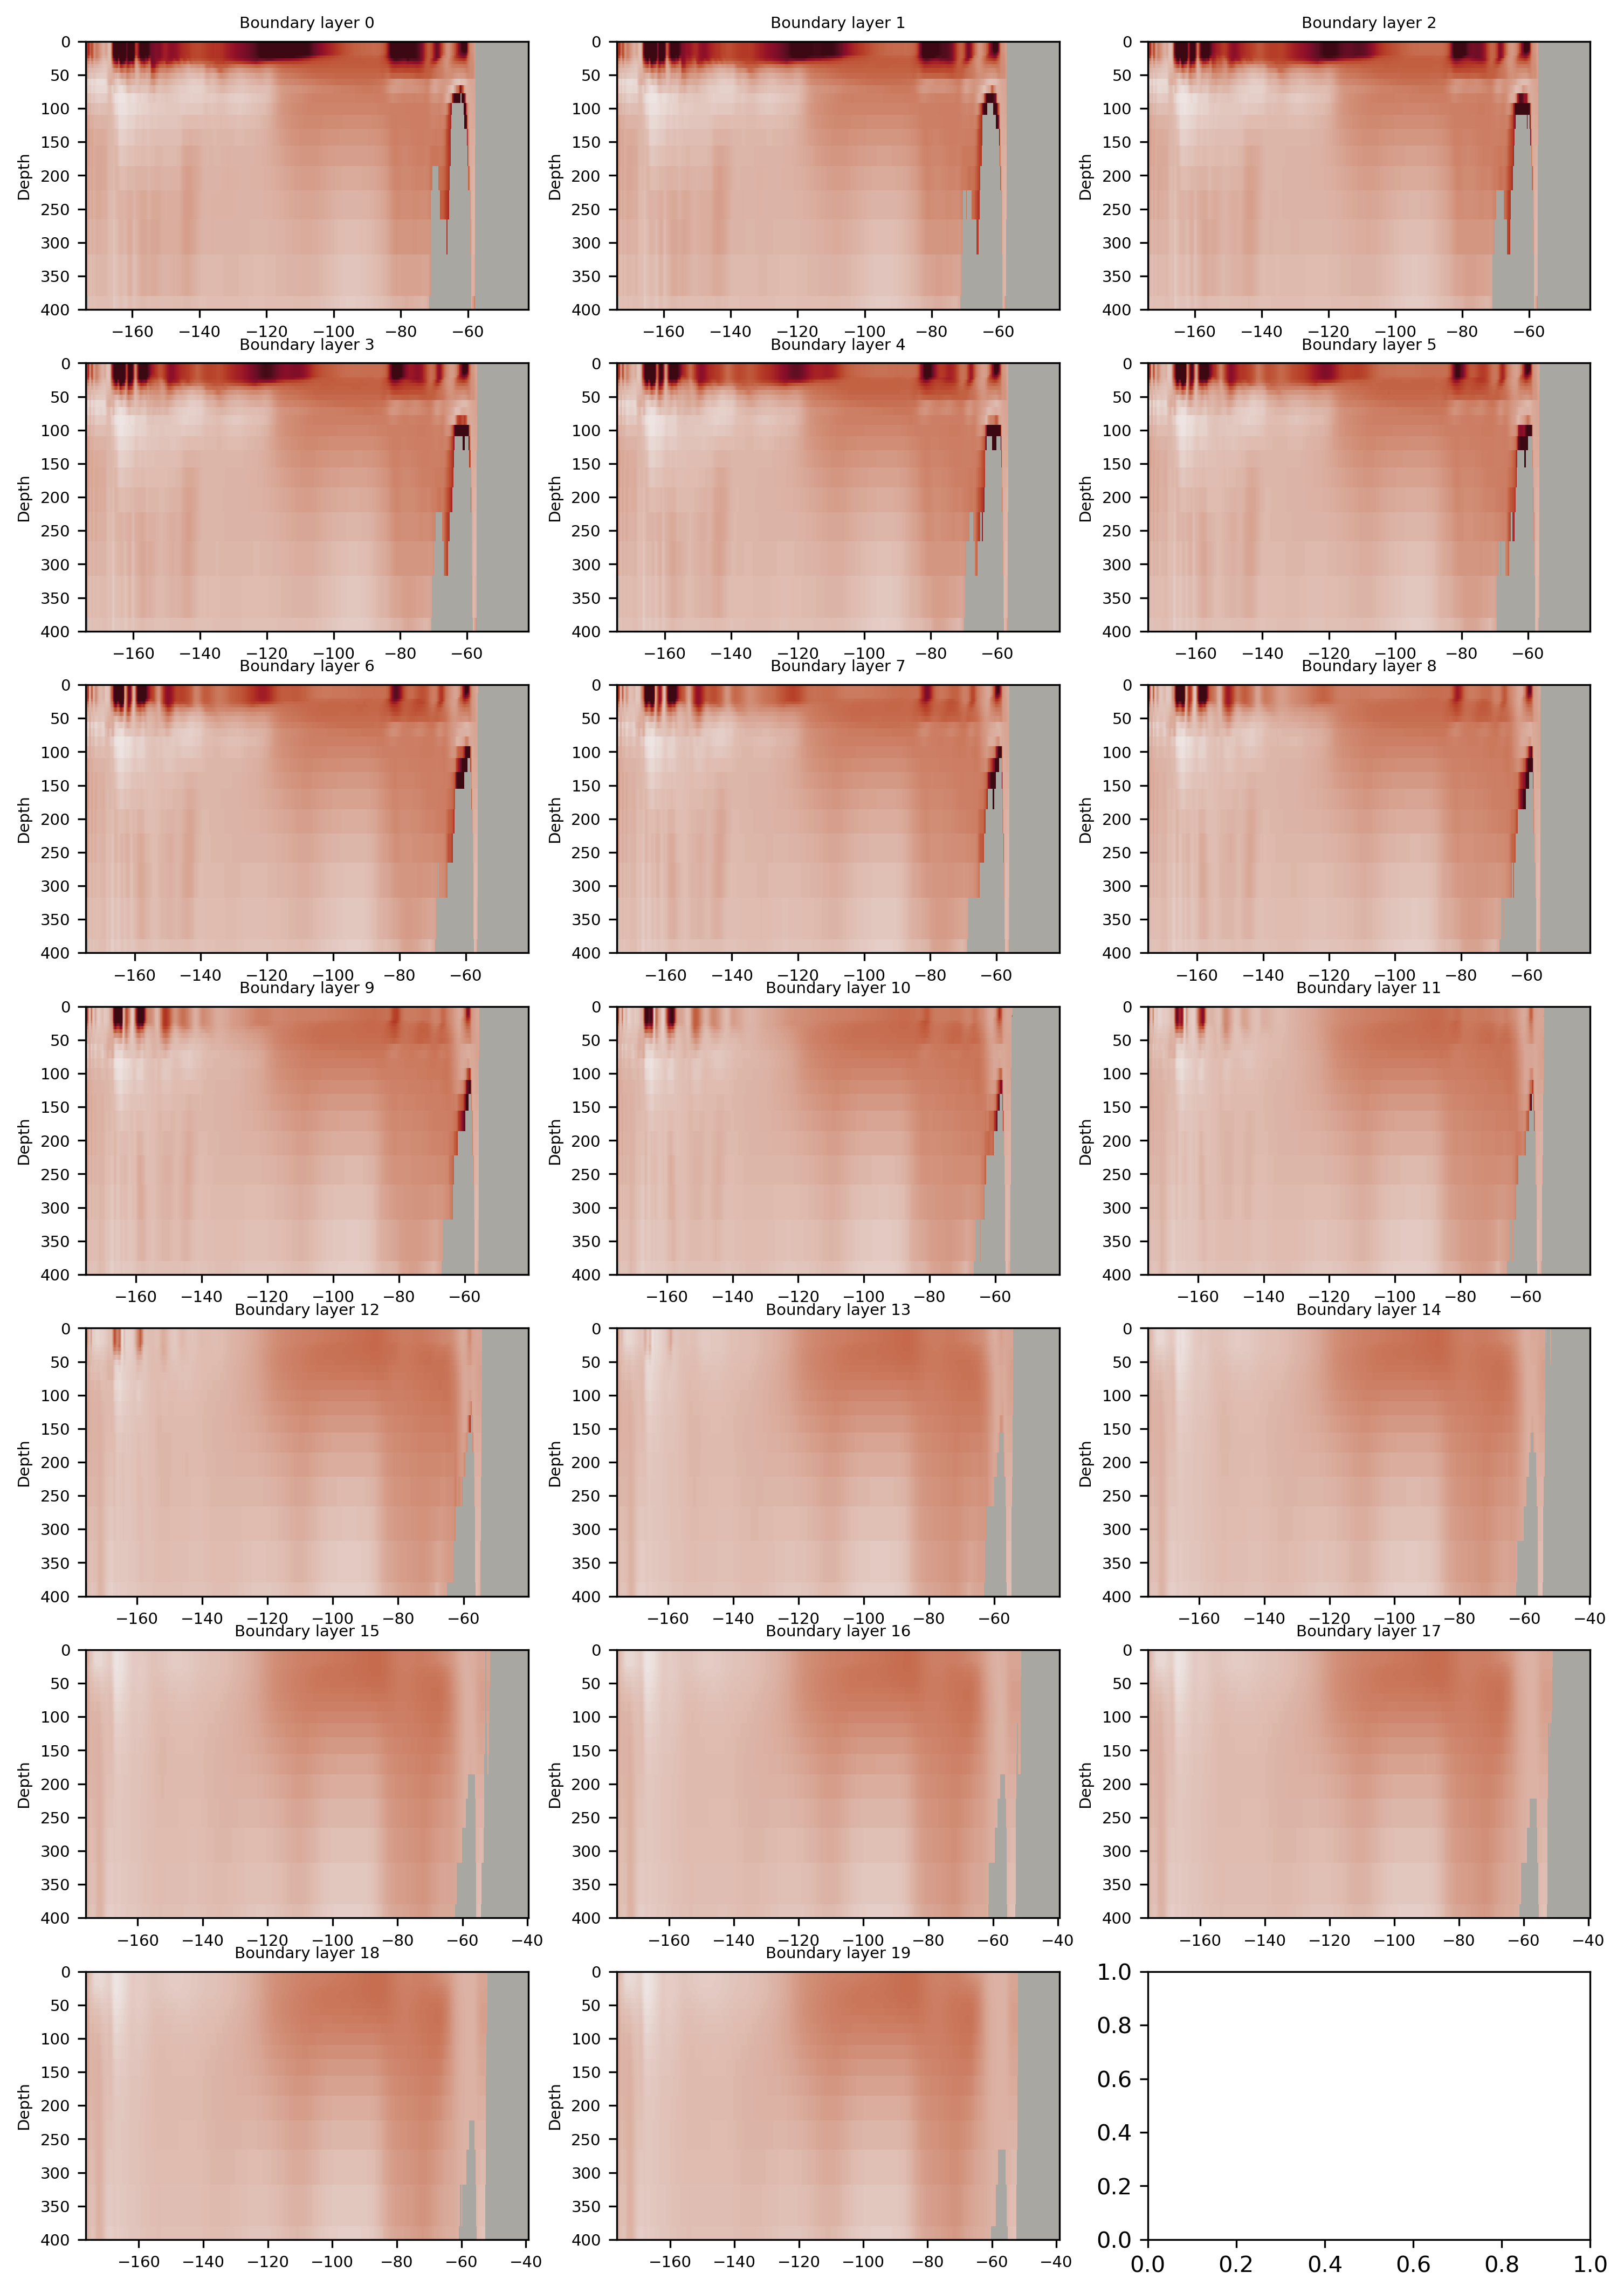

In [32]:
layer = 0
month = 8

(bdyimin, bdyimax, bdyjmin, bdyjmax) = E_coordinates
    
# Latitude of boundary:
lons_bdy = ANHA12_lon[bdyimin:bdyimax,bdyjmin:bdyjmax]
    
### Figure:
fig, ax = plt.subplots(7,3, figsize=(12,18), dpi=300)

for i, axis in enumerate(ax.ravel()):
    if i < 20:
        lons      = lons_bdy[:,i]                                    # longitude of boundary transect
        mesh_bdy  = bathy_masked[:,bdyimin:bdyimax,bdyjmin+i]        # bathymetry of boundary transect
        diff_plot = dMn_new[month,:,bdyimin-imin:bdyimax-imin,bdyjmin-jmin+i]
        CB1       = axis.pcolormesh(lons, mesh_depth, diff_plot, vmin=-3, vmax=3, cmap=cmocean.cm.balance, zorder=1)
        
        # labels
        axis.set_title(f'Boundary layer {i}', fontsize=7)
        axis.set_ylabel('Depth', fontsize=7)
        axis.invert_yaxis()
        axis.set_ylim(400,0)
        axis.tick_params(axis='both', labelsize=7)
        axis.pcolormesh(lons, mesh_depth, mesh_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)

In [ ]:
layer = 0
month = 8

(bdyimin, bdyimax, bdyjmin, bdyjmax) = N_coordinates
    
# Latitude of boundary:
lats_bdy = ANHA12_lat[bdyimin:bdyimax,bdyjmin:bdyjmax]
    
### Figure:
fig, ax = plt.subplots(4,3, figsize=(12,12), dpi=300)

for i, axis in enumerate(ax.ravel()):
    if i < 10:
        lats      = lats_bdy[i,:]                                    # longitude of boundary transect
        mesh_bdy  = bathy_masked[:,bdyimin+i,bdyjmin:bdyjmax]        # bathymetry of boundary transect
        diff_plot = dMn_new[month,:,bdyimin-imin+i,bdyjmin-jmin:bdyjmax-jmin]
        CB1       = axis.pcolormesh(lats, mesh_depth, diff_plot, vmin=-3, vmax=3, cmap=cmocean.cm.balance, zorder=1)
        
        # labels
        axis.set_title(f'Boundary layer {i}', fontsize=7)
        axis.set_ylabel('Depth', fontsize=7)
        axis.invert_yaxis()
        axis.set_ylim(400,0)
        axis.set_xlim(68,75)
        axis.tick_params(axis='both', labelsize=7)
        axis.pcolormesh(lats, mesh_depth, mesh_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)

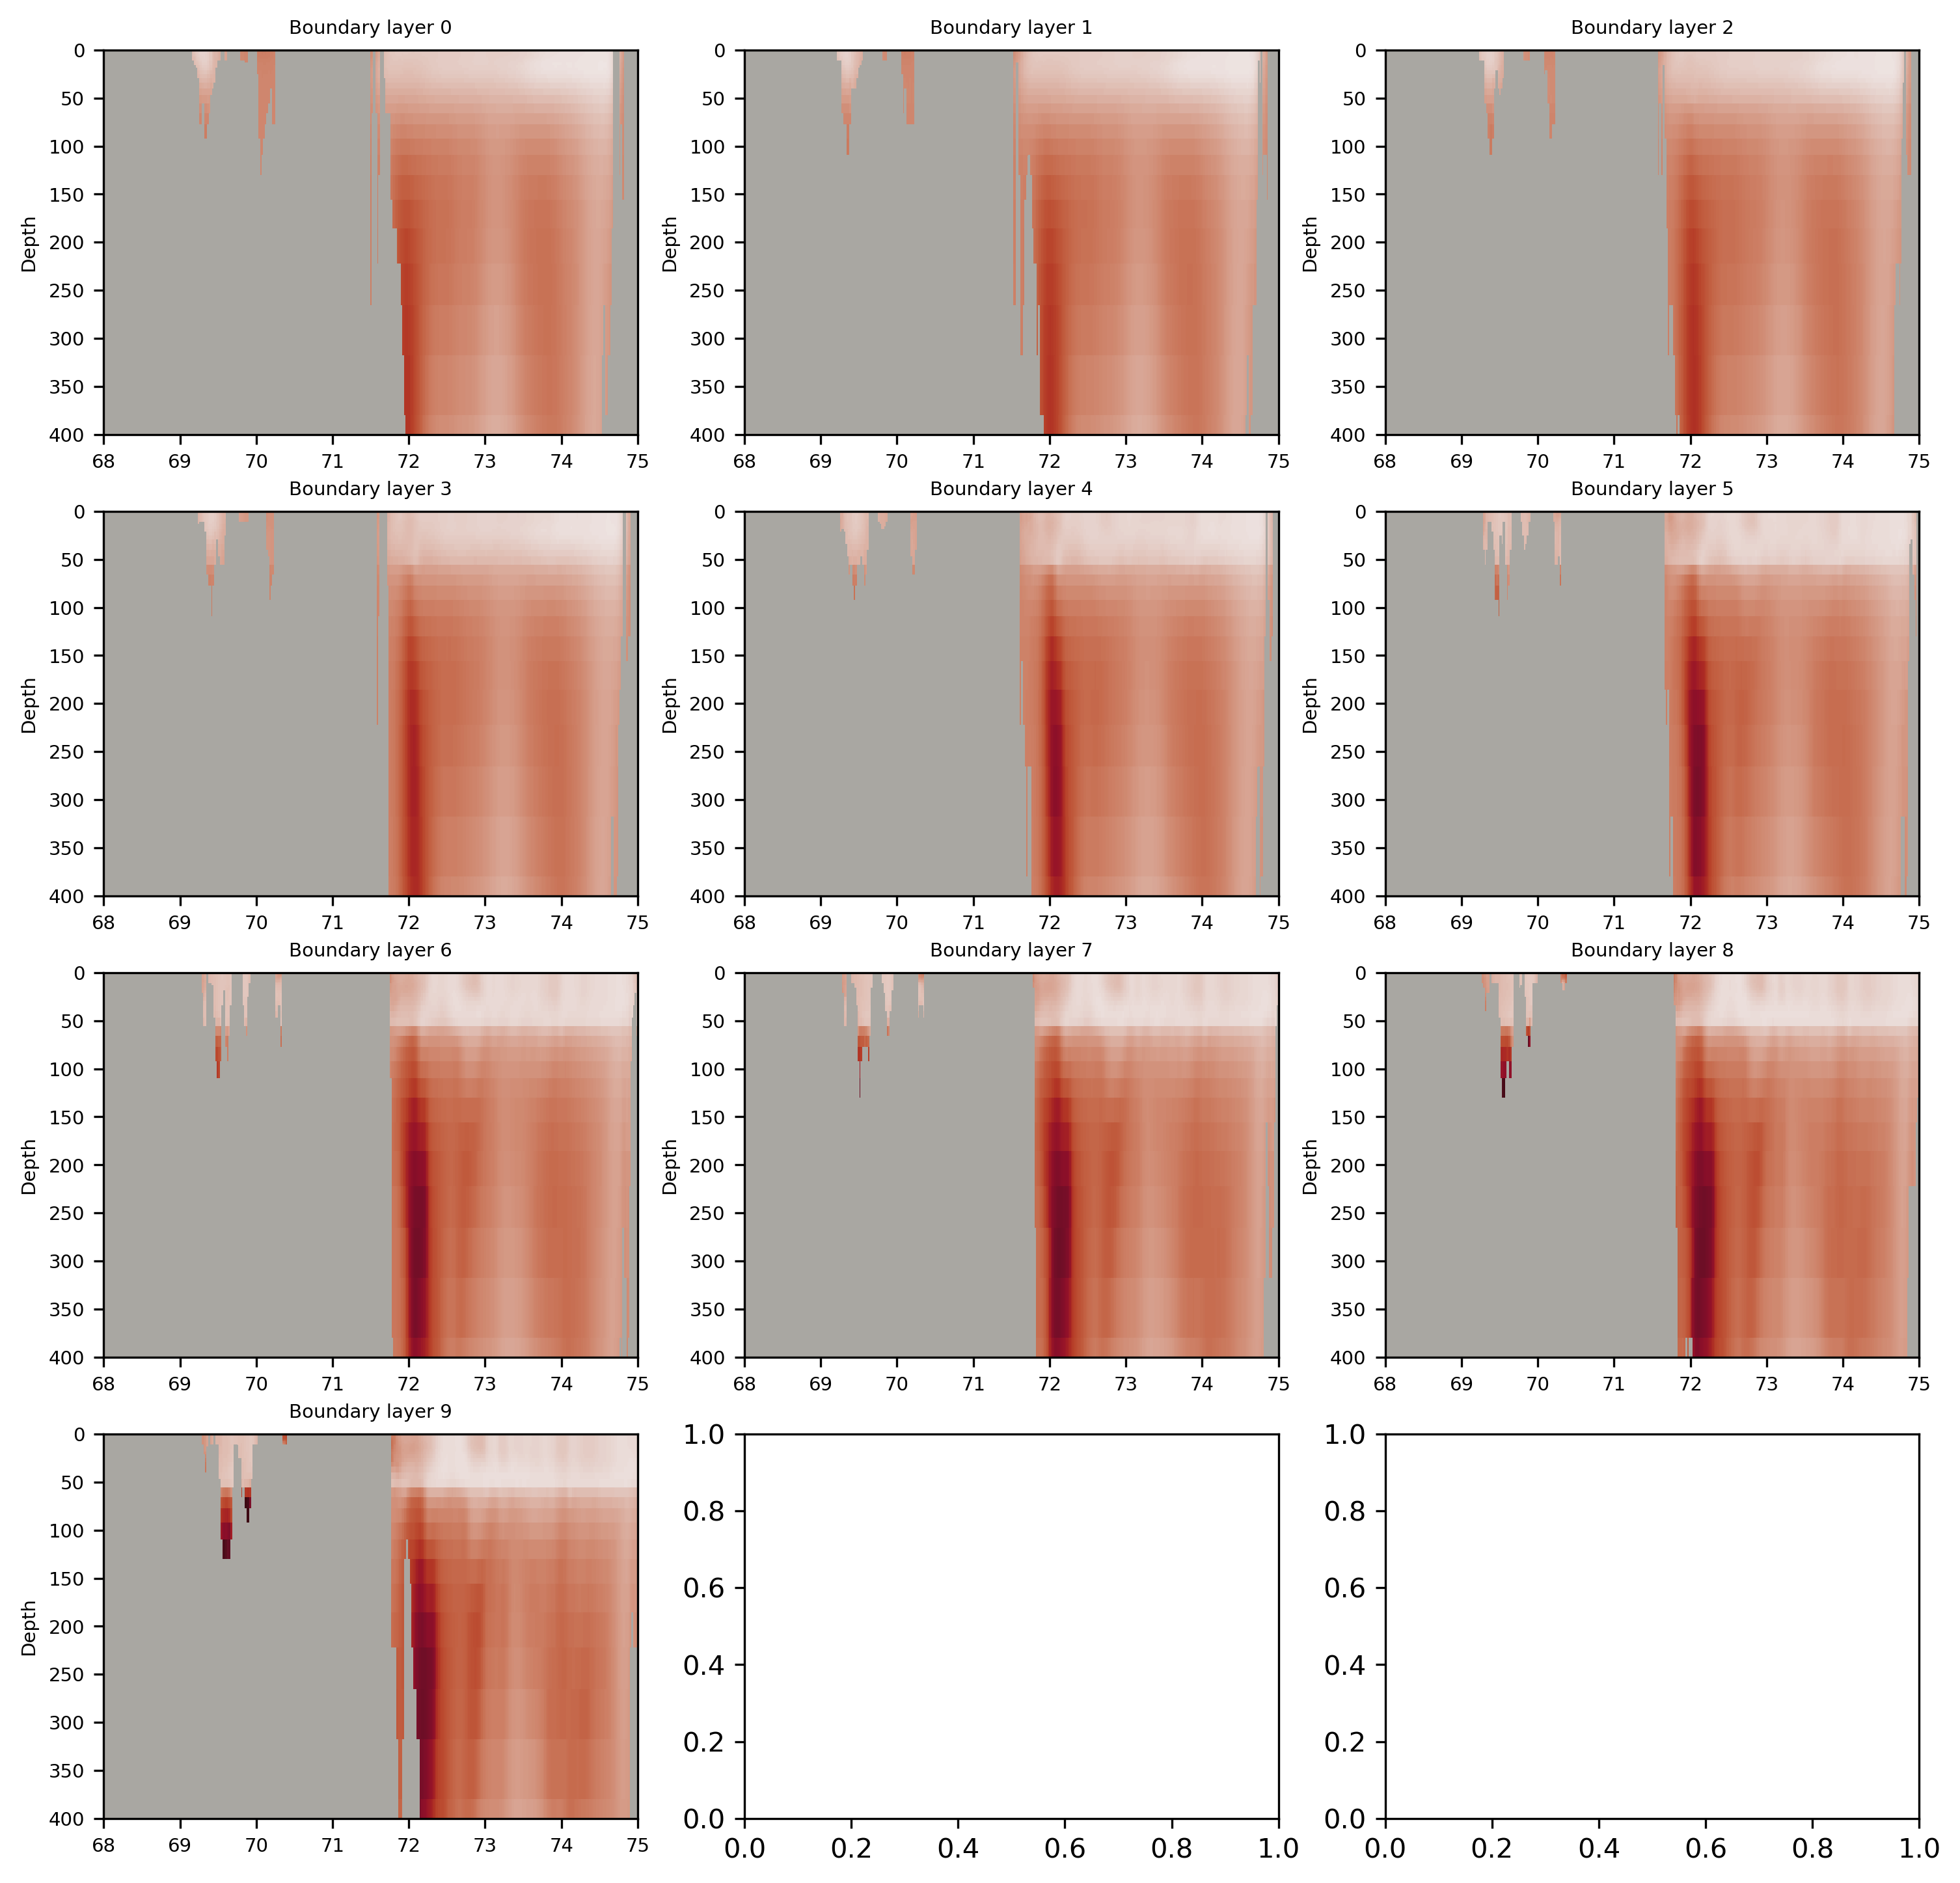

In [34]:
layer = 0
month = 8

(bdyimin, bdyimax, bdyjmin, bdyjmax) = S_coordinates
    
# Latitude of boundary:
lats_bdy = ANHA12_lat[bdyimin:bdyimax,bdyjmin:bdyjmax]
    
### Figure:
fig, ax = plt.subplots(4,3, figsize=(12,12), dpi=300)

for i, axis in enumerate(ax.ravel()):
    if i < 10:
        lats      = lats_bdy[i,:]                                    # longitude of boundary transect
        mesh_bdy  = bathy_masked[:,bdyimin+i,bdyjmin:bdyjmax]        # bathymetry of boundary transect
        diff_plot = dMn_new[month,:,bdyimin-imin+i,bdyjmin-jmin:bdyjmax-jmin]
        CB1       = axis.pcolormesh(lats, mesh_depth, diff_plot, vmin=-3, vmax=3, cmap=cmocean.cm.balance, zorder=1)
        
        # labels
        axis.set_title(f'Boundary layer {i}', fontsize=7)
        axis.set_ylabel('Depth', fontsize=7)
        axis.invert_yaxis()
        axis.set_ylim(400,0)
        axis.set_xlim(68,75)
        axis.tick_params(axis='both', labelsize=7)
        axis.pcolormesh(lats, mesh_depth, mesh_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)